# Recurrent neural network: spam detection

In [21]:
# Standard library
import re
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

RANDOM_SEED = 315

## 1. Data loading

### 1.1. Load the data from URL

In [2]:
# Read csv file into dataframe
data_df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Save a local copy

In [3]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/urls.parquet')

### 1.3. Inspect the data

In [4]:
data_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.0+ KB


## 2. EDA

### 2.1. Label frequency

First, let's just take a look at how many 'spam' vs 'not spam' urls we have:

In [6]:
label_counts = data_df['is_spam'].value_counts()

not_spam = label_counts.iloc[0]
spam = label_counts.iloc[1]

print(f'URLs are {(not_spam/(spam + not_spam)*100):.1f}% not spam')

URLs are 89.7% not spam


This is unbalanced, but not extremely so - we may not need to do anything with this information. But, it is good to keep it in mind as we work through EDA and modeling.

### 2.2. URL length distribution

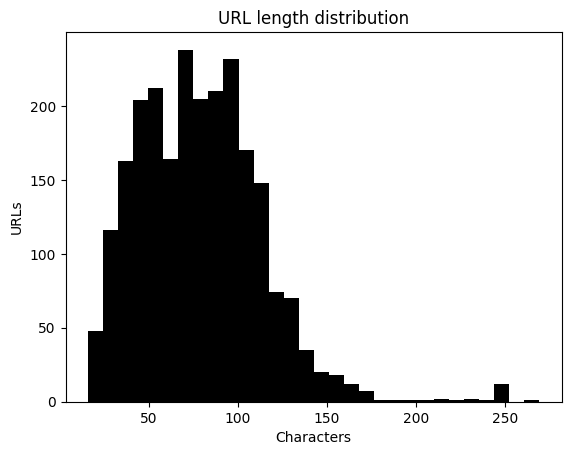

URL length mean: 79
URL length min: 16
URL length max: 269


In [7]:
data_df['URL_length'] = data_df['url'].str.len().tolist()

plt.title('URL length distribution')
plt.xlabel('Characters')
plt.ylabel('URLs')
plt.hist(data_df['URL_length'], bins=30, color='black')
plt.show()

print(f"URL length mean: {np.mean(data_df['URL_length']):.0f}")
print(f"URL length min: {min(data_df['URL_length']):.0f}")
print(f"URL length max: {max(data_df['URL_length']):.0f}")

### 2.3. Short URLs

In [8]:
short_urls = data_df[data_df['URL_length'] < 20]
short_urls

,url,is_spam,URL_length
150,https://neeva.co/,False,17
656,https://qz.com/app/,False,19
676,https://digg.com/,True,17
728,https://uqora.com/,True,18
963,https://tim.blog/,True,17
971,http://abw.blue/,False,16
978,https://mowned.com/,False,19
995,https://waxy.org/,True,17
1158,https://hey.com/,True,16
1469,https://woven.com/,False,18


### 2.4. Long URLs

In [9]:
long_urls = data_df[data_df['URL_length'] > 200]
long_urls

,url,is_spam,URL_length
472,https://www.youtube.com/watch?v=4An0ndagZsQ&fe...,False,244
479,https://www.youtube.com/watch?v=oieBnV_HFB0&fe...,False,244
480,https://www.youtube.com/watch?v=PQmDUEv939A&fe...,False,244
481,https://www.youtube.com/watch?v=QrGEIWe0JXY&fe...,False,244
587,https://www.youtube.com/watch?v=S0qrinhNnOM&fe...,False,244
663,https://www.youtube.com/watch?v=gbCREJh6aCc&fe...,False,244
914,https://www.npr.org/sections/live-updates-prot...,False,269
1285,https://www.youtube.com/watch?v=SrLZgP-OR6s&ut...,False,227
1286,https://www.youtube.com/watch?v=N13WI3oVda8&ut...,False,227
1290,https://www.youtube.com/watch?v=Yz3mQhuMACs&fe...,False,244


## 3. Data preprocessing

### 3.1. Label encoding

In [10]:
data_df['is_spam'] = data_df['is_spam'].astype(str)
data_df['is_spam'] = data_df['is_spam'].replace({'True': '1', 'False': '0'})
data_df['is_spam'] = data_df['is_spam'].astype(int)

### 3.2. URL splitting

In [11]:
def domain_splitter(url:str) -> list:
    '''Splits URLs on non-word characters, then joins on space
    for compatibility with the Tensorflow text vectorizer'''

    return ' '.join(re.findall(f'[\w`]+', url))

data_df['url'] = data_df['url'].apply(domain_splitter)
data_df.head()

,url,is_spam,URL_length
0,https briefingday us8 list manage com unsubscribe,1,51
1,https www hvper com,1,22
2,https briefingday com m v4n3i4f3,1,34
3,https briefingday com n 20200618 m commentform,0,48
4,https briefingday com fan,1,27


### 3.1. Train-test split

In [12]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=RANDOM_SEED)
print(f'Test data: {test_df.shape}')

Test data: (711, 3)


### 3.1. Train-validation split

In [13]:
training_df, validation_df = train_test_split(train_df, test_size=0.3, random_state=RANDOM_SEED)
print(f'Training data: {train_df.shape}')
print(f'Validation data: {validation_df.shape}')

Training data: (1658, 3)
Validation data: (498, 3)


In [14]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1160 entries, 1493 to 1774
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   url         1160 non-null   object
 1   is_spam     1160 non-null   int64 
 2   URL_length  1160 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 36.2+ KB


## 3. RNN model

### 3.2. Text encoder

In [15]:
training_features = train_df['url'].to_numpy()
validation_features = validation_df['url'].to_numpy()
testing_features = test_df['url'].to_numpy()

encoder = tf.keras.layers.TextVectorization(
    max_tokens=500,
    output_mode='tf_idf',
    sparse=False,
    split='whitespace'
)

encoder.adapt(training_features)

vocab = np.array(encoder.get_vocabulary())
print(f'Vocabulary size: {len(vocab)}\n')
print(f'Training features shape: {training_features.shape}')
print(f'Training labels shape: {train_df["is_spam"].to_numpy().shape}\n')
print(f'Validation features shape: {validation_features.shape}')
print(f'Validation labels shape: {validation_df["is_spam"].to_numpy().shape}')

Vocabulary size: 500

Training features shape: (1658,)
Training labels shape: (1658,)

Validation features shape: (498,)
Validation labels shape: (498,)


### 3.2. Model definition

In [16]:
input_dim = len(encoder.get_vocabulary())

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=input_dim,
        output_dim=16
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.00001),
    metrics=['accuracy']
)

### 3.3. Class weighting

In [17]:
total = len(train_df['is_spam'])
pos = sum(train_df['is_spam'])
neg = total-pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.63


### 3.3. Model training

In [18]:
epochs = 50
batch_sizes = [1, 2, 4, 8]

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



CPU times: user 21h 6min 49s, sys: 2h 6min 40s, total: 23h 13min 30s
Wall time: 6h 31min 54s


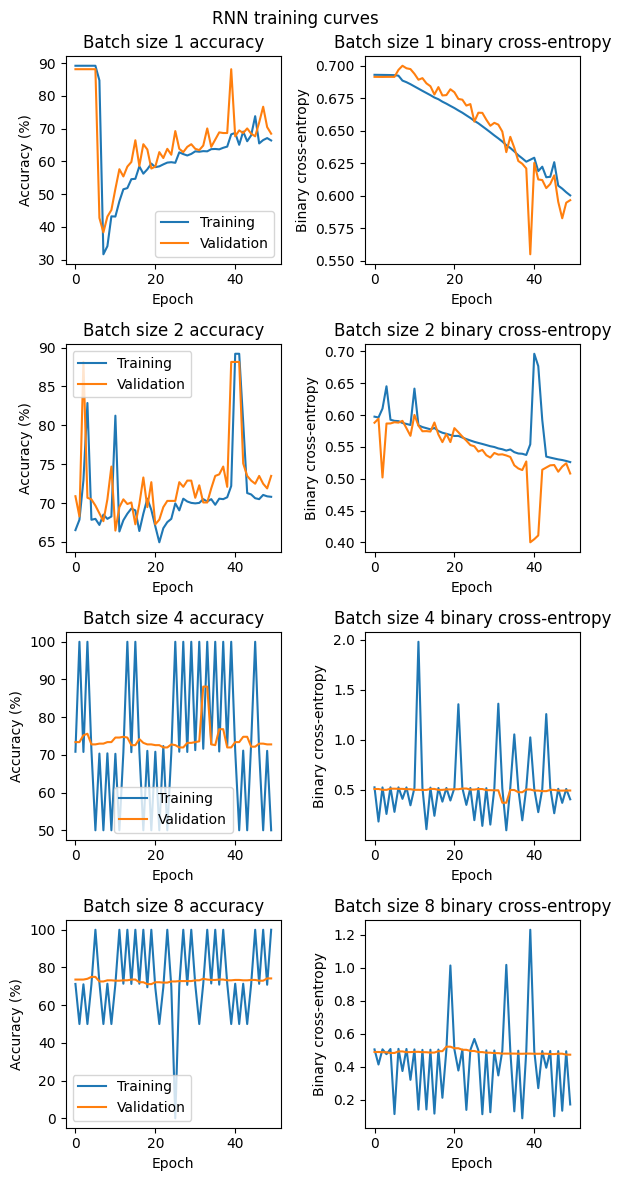

In [19]:
%%time

# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs = plt.subplots(len(batch_sizes),2, figsize=(6,3*len(batch_sizes)))

# Add the main title
fig.suptitle('RNN training curves', size='large')

for i, batch_size in enumerate(batch_sizes):

    steps_per_epoch = len(training_features) // batch_size
    validation_steps = len(validation_features) // batch_size

    training_results = model.fit(
        x=training_features,
        y=train_df['is_spam'],
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_data=(validation_features, validation_df['is_spam']),
        validation_steps=validation_steps,
        class_weight=class_weight,
        verbose=0
    )

    # Plot training and validation accuracy
    axs[i, 0].set_title(f'Batch size {batch_size} accuracy')
    axs[i, 0].plot(np.array(training_results.history['accuracy']) * 100, label='Training')
    axs[i, 0].plot(np.array(training_results.history['val_accuracy']) * 100, label='Validation')
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].set_ylabel('Accuracy (%)')
    axs[i, 0].legend(loc='best')

    # Plot training and validation binary cross-entropy
    axs[i, 1].set_title(f'Batch size {batch_size} binary cross-entropy')
    axs[i, 1].plot(training_results.history['loss'])
    axs[i, 1].plot(training_results.history['val_loss'])
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].set_ylabel('Binary cross-entropy')

fig.tight_layout()
print()

In [18]:
batch_size = 1
epochs = 200


CPU times: user 1d 18h 58min 2s, sys: 3h 42min 49s, total: 1d 22h 40min 51s
Wall time: 14h 2min 19s


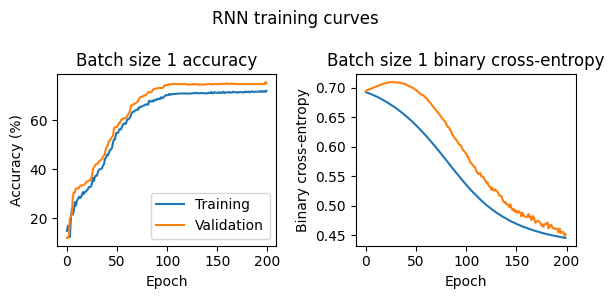

In [19]:
%%time

# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs = plt.subplots(1,2, figsize=(6,3))

# Add the main title
fig.suptitle('RNN training curves', size='large')

steps_per_epoch = len(training_features) // batch_size
validation_steps = len(validation_features) // batch_size

training_results = model.fit(
    x=training_features,
    y=train_df['is_spam'],
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(validation_features, validation_df['is_spam']),
    validation_steps=validation_steps,
    class_weight=class_weight,
    verbose=0
)

# Plot training and validation accuracy
axs[0].set_title(f'Batch size {batch_size} accuracy')
axs[0].plot(np.array(training_results.history['accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='best')

# Plot training and validation binary cross-entropy
axs[1].set_title(f'Batch size {batch_size} binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

fig.tight_layout()
print()

## 4. Model evaluation

### 4.1. Test set predictions

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


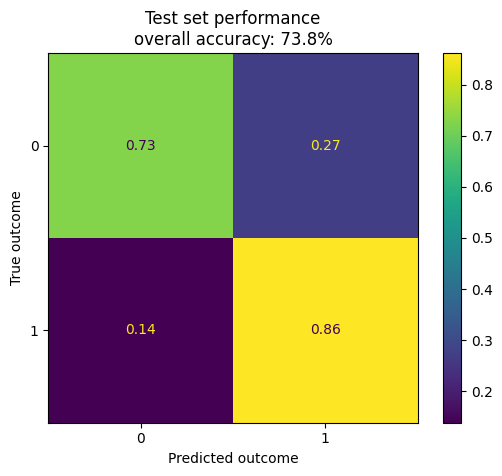

In [22]:
threshold = 0.5
predictions = model.predict(tf.convert_to_tensor(testing_features))
predictions = [1 if p > threshold else 0 for p in predictions]

accuracy = accuracy_score(predictions, test_df['is_spam'])*100

# Plot the confusion matrix
cm = confusion_matrix(test_df['is_spam'], predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_= cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 5. Save assets

In [24]:
model.save('../models/optimized_rnn.keras')